# 2D Gaussian Test
The purpose of this notebook is to explore our analysis using a double Gaussian as a test bed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import time
from scipy.optimize import curve_fit
%matplotlib inline

# Create the 2D Gaussian
Let's do an x mean of 1 +/- .5 and y mean of 2 +/- 0.75

In [2]:
def Gauss_prob(values,mean,sigma):
    '''
    Calculates Gaussain probability at each data point
    
    Arguments:
        values: The data values of interest
        mean: The mean of the Gaussian
        sigma: The sigma of the Gaussian
    Returns:
       A numpy array of probabilities, one for each value.
    '''
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((values-mean)/sigma)**2)

def Gauss2d(data,x0,y0,x_sig,y_sig):
    z = 1/(2*np.pi*x_sig*y_sig) * np.exp(-1/2*((data[0]-x0)**2/(x_sig**2)+(data[1]-y0)**2/(y_sig**2)))
    return z

def get_chisq(x,y,z_noise,zerr_arr,param):
    zfit = Gauss2d([x,y],*param)

    chisq = np.sum(((z_noise - zfit)/zerr_arr)**2)
    return chisq

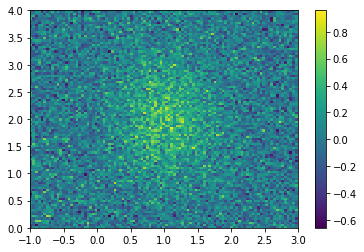

In [3]:
np.random.seed(100)
num = 100
xrange = np.linspace(-1,3,num)
yrange = np.linspace(0,4,num)

X, Y = np.meshgrid(xrange, yrange)

Z = Gauss2d([X,Y],1,2,0.5,0.75)

x = X.flatten()
y = Y.flatten()

zerr = 0.2  #The true Error bar
factor = 1.0 #Inflating or deflating the reported errorbar

zerr_arr = np.zeros(len(x)) + zerr*factor
Z_noise = Z + np.random.standard_normal(Z.shape)*zerr
z = Z.flatten()
z_noise = Z_noise.flatten()

plt.pcolormesh(X,Y,Z_noise)
plt.colorbar()
plt.show()

In [4]:
num = 200
xfitrange = np.linspace(0.75,1.25,num)
yfitrange = np.linspace(1.75,2.25,num)

X_sm, Y_sm = np.meshgrid(xfitrange, yfitrange)

x_sm = X_sm.flatten()
y_sm = Y_sm.flatten()

## Let's fit the data fixing X and Y

In [5]:
(param,cov) = curve_fit(Gauss2d,[x,y],z_noise,sigma=zerr_arr)
print("X0: {:.4f} +/- {:.5f}".format(param[0],np.sqrt(cov[0,0])))
print("Y0: {:.4f} +/- {:.5f}".format(param[1],np.sqrt(cov[1,1])))
print("Xsig: {:.4f} +/- {:.5f}".format(param[2],np.sqrt(cov[2,2])))
print("Ysig: {:.4f} +/- {:.5f}".format(param[3],np.sqrt(cov[3,3])))
print("Chi Squared: {:.3f}".format(get_chisq(x,y,z_noise,zerr_arr,param)))

X0: 1.0124 +/- 0.01226
Y0: 1.9968 +/- 0.01944
Xsig: 0.4888 +/- 0.01063
Ysig: 0.7740 +/- 0.01695
Chi Squared: 10122.618


## Do a grid search in $X_0$ and $Y_0$

In [6]:
#I assume equal space gridding
x_width = (np.max(x_sm) - np.min(x_sm)) / num 
y_width = (np.max(y_sm) - np.min(y_sm)) / num 
print(x_width,y_width)

0.0025 0.0025


In [7]:
x_fit = list()
y_fit = list()
xsig_fit = list()
ysig_fit = list()
chisq = list()

time_ind = np.floor(len(x_sm)/10)
j = 1
beg_time = time.time()

for i in range(len(x_sm)):
    if i == (time_ind * j):
        print("Time Elapsed: {:.2f} min Percent Done: {:.0f}%".format((time.time()-beg_time)/60,j*10))
        j=j+1
    #Set boundaries to be centered on each x,y point with the 1/1000 width of that grid point
    (param,cov) = curve_fit(Gauss2d,[x,y],z_noise,sigma=zerr_arr,
                                bounds=([x_sm[i]-(x_width/1000),y_sm[i]-(y_width/1000),-np.inf,-np.inf]
                               ,[x_sm[i]+(x_width/1000),y_sm[i]+(y_width/1000),np.inf,np.inf]))
    x_fit.append(param[0])
    y_fit.append(param[1])
    xsig_fit.append(param[2])
    ysig_fit.append(param[3])
    chisq.append(get_chisq(x,y,z_noise,zerr_arr,param))

print("Total Time: {:.2f} min".format((time.time()-beg_time)/60))

x_fit_arr = np.array(x_fit)   
y_fit_arr = np.array(y_fit) 
xsig_fit_arr = np.array(xsig_fit)         
ysig_fit_arr = np.array(ysig_fit)     
chisq_arr = np.array(chisq)

Time Elapsed: 1.06 min Percent Done: 10%
Time Elapsed: 2.13 min Percent Done: 20%
Time Elapsed: 3.17 min Percent Done: 30%
Time Elapsed: 4.17 min Percent Done: 40%
Time Elapsed: 5.25 min Percent Done: 50%
Time Elapsed: 6.28 min Percent Done: 60%
Time Elapsed: 7.38 min Percent Done: 70%
Time Elapsed: 8.77 min Percent Done: 80%
Time Elapsed: 10.14 min Percent Done: 90%
Total Time: 11.58 min


## Deriving Mean and Standard Deviation from probability
* Flat Prior
  * $\chi^2_i$ is the chi squared (not reduced $\chi^2$). I will subtract off the minimum $\chi^2 + 1$ to help 
     keep the exponentials in line. I do the plus 1 to avoid issues with log of 0.
  * Mean: $$<X> = \frac{\sum_i X_i \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
  * Variance: $$<(X-<X>)^2> = \frac{\sum_i (X_i-<X>)^2 \exp{\frac{-\chi^2_i}{2}}}{\sum_i \exp{\frac{-\chi^2_i}{2}}}$$
* Gaussian Prior centered on asteroseismic $\log g_0$ with $\sigma_{\log g}$.
$$\exp{\frac{-\chi^2_i}{2}} \rightarrow \exp{\frac{-\chi^2_i}{2}} \exp{\frac{-(\log g_i-\log g_0 )^2}{2(\sigma_{\log g}^2)}}$$
  * $\log g$ prior should be $2.564 \pm 0.01$

In [8]:
best_chisq = np.min(chisq_arr)
chisq_hold_arr = chisq_arr
chisq_arr = chisq_arr - best_chisq + 1

1.01130653266 1.99623115578


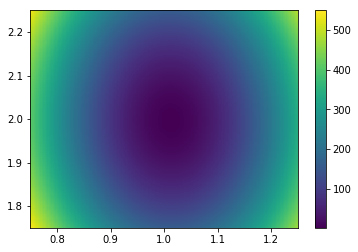

In [9]:
CHISQ_arr = chisq_arr.reshape(X_sm.shape)
plt.pcolormesh(X_sm,Y_sm,CHISQ_arr)
ind = np.argmin(chisq_arr)
print(x_sm[ind],y_sm[ind])
plt.colorbar()
plt.show()

In [10]:
def get_mean_std(values,chisq):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
    Returns:
       The mean and standard deviation
    '''
    lh = np.exp(-chisq/2) #Likelihood
    lh_mean = np.sum(values*lh)
    norm = np.sum(lh)
    mean = lh_mean/norm
    lh_std = np.sum((values-mean)**2*lh)
    std = np.sqrt(lh_std/norm)
    return(mean,std)
def get_mean_std_prior(values,chisq,prior_val,prior_mean,prior_std):
    '''
    Calculates mean and standard deviation by calculating the expectation value of the mean and variance.
    It includes a Gaussian prior.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
    Returns:
        The mean and standard deviation
    '''
    #Likliehood and Gaussian Prior
    lh_prior = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) 
    lh_prior_mean = np.sum(values*lh_prior)
    norm = np.sum(lh_prior)
    mean = lh_prior_mean/norm
    lh_prior_std = np.sum((values-mean)**2*lh_prior)
    std = np.sqrt(lh_prior_std/norm)
    return(mean,std)

In [11]:
(param,cov) = curve_fit(Gauss2d,[x,y],z_noise,sigma=zerr_arr)
print("X0: {:.4f} +/- {:.5f}".format(param[0],np.sqrt(cov[0,0])))
print("Y0: {:.4f} +/- {:.5f}".format(param[1],np.sqrt(cov[1,1])))
print("Xsig: {:.4f} +/- {:.5f}".format(param[2],np.sqrt(cov[2,2])))
print("Ysig: {:.4f} +/- {:.5f}".format(param[3],np.sqrt(cov[3,3])))

X0: 1.0124 +/- 0.01226
Y0: 1.9968 +/- 0.01944
Xsig: 0.4888 +/- 0.01063
Ysig: 0.7740 +/- 0.01695


In [12]:
x_mean,x_std = get_mean_std(x_fit_arr,chisq_arr)
print("X0: {:.4f} +/- {:.6f}".format(x_mean,x_std))
y_mean,y_std = get_mean_std(y_fit_arr,chisq_arr)
print("Y0: {:.4f} +/- {:.6f}".format(y_mean,y_std))
xsig_mean,xsig_std = get_mean_std(xsig_fit_arr,chisq_arr)
print("Xsig: {:.4f} +/- {:.6f}".format(xsig_mean,xsig_std))
ysig_mean,ysig_std = get_mean_std(ysig_fit_arr,chisq_arr)
print("Ysig: {:.4f} +/- {:.6f}".format(ysig_mean,ysig_std))

X0: 1.0124 +/- 0.012198
Y0: 1.9969 +/- 0.019362
Xsig: 0.4890 +/- 0.000398
Ysig: 0.7742 +/- 0.000796


## Show Distributions

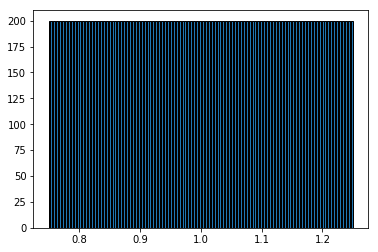

In [13]:
num_sm = X_sm.shape[0]
plt.hist(x_fit_arr,num_sm,edgecolor='black')
plt.show()

In [14]:
def get_posterior(values,chisq,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    lh_prob = np.exp(-chisq/2)
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prob[(prob_idx-1 == i)])) #digitize returns the 
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)
def get_posterior_prior(values,chisq,prior_val,prior_mean,prior_std,num_bins):
    '''
    Calculates the posterior probability distribution as a function of the values and chi-squared.
    
    Arguments:
        values: The data values of interest
        chisq: The chi squared of each values value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        numbins: The bining you want to use. I generally default to the number of grid points.
    Returns:
       Tuple (prob_arr,bin_center)
       prob_arr: The probability array
       bin_center: The center of each bin the probability array represents
    '''
    #I assume equal space gridding
    hist,bin_edges = np.histogram(values,num_bins)
    prob_idx = np.digitize(values,bin_edges)
    lh_prior_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2)/prior_std**2) #Likliehood and Gaussian Prior
    norm = np.sum(lh_prior_prob)
    lh_prior_prob = lh_prior_prob/norm
    prob = list()
    for i in range(len(hist)):
        prob.append(np.sum(lh_prior_prob[(prob_idx-1 == i)])) #digitize returns the right bin hisogram the left
    prob_arr = np.array(prob)
    bin_center = (bin_edges[1:] - bin_edges[0:-1]) / 2 + bin_edges[0:-1]
    return(prob_arr,bin_center)

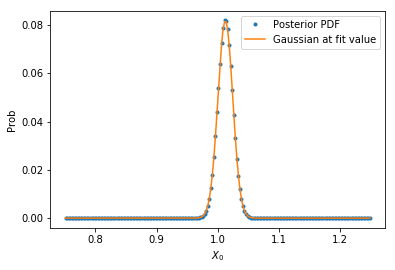

In [15]:
x_prob,xcenter = get_posterior(x_fit_arr,chisq_arr,num_sm)
plt.plot(xcenter,x_prob,'.',label='Posterior PDF')
plt.plot(xcenter,Gauss_prob(xcenter,x_mean,x_std)/np.sum(Gauss_prob(xcenter,x_mean,x_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$X_0$")
plt.ylabel("Prob")
plt.legend()
plt.show()

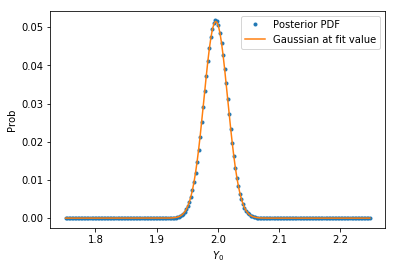

In [16]:
y_prob,ycenter = get_posterior(y_fit_arr,chisq_arr,num_sm)
plt.plot(ycenter,y_prob,'.',label='Posterior PDF')
plt.plot(ycenter,Gauss_prob(ycenter,y_mean,y_std)/np.sum(Gauss_prob(ycenter,y_mean,y_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$Y_0$")
plt.ylabel("Prob")
plt.legend()
plt.show()

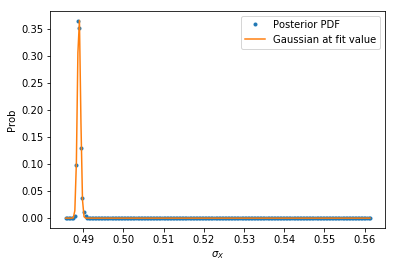

In [17]:
xsig_prob,xsigcenter = get_posterior(xsig_fit_arr,chisq_arr,int(num_sm))
plt.plot(xsigcenter,xsig_prob,'.',label='Posterior PDF')
plt.plot(xsigcenter,Gauss_prob(xsigcenter,xsig_mean,xsig_std)/np.sum(Gauss_prob(xsigcenter,xsig_mean,xsig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X$")
plt.ylabel("Prob")
plt.legend()
plt.show()

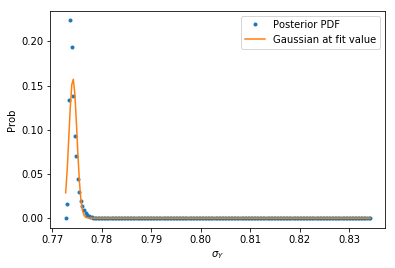

In [18]:
ysig_prob,ysigcenter = get_posterior(ysig_fit_arr,chisq_arr,int(num_sm))
plt.plot(ysigcenter,ysig_prob,'.',label='Posterior PDF')
plt.plot(ysigcenter,Gauss_prob(ysigcenter,ysig_mean,ysig_std)/np.sum(Gauss_prob(ysigcenter,ysig_mean,ysig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_Y$")
plt.ylabel("Prob")
plt.legend()
plt.show()

## Now using a Prior
Let's give a prior on $X_0$ of $1.0 \pm 0.008$

In [19]:
#No Prior
x_mean,x_std = get_mean_std(x_fit_arr,chisq_arr)
print("X0: {:.4f} +/- {:.4f}".format(x_mean,x_std))
y_mean,y_std = get_mean_std(y_fit_arr,chisq_arr)
print("Y0: {:.4f} +/- {:.4f}".format(y_mean,y_std))
xsig_mean,xsig_std = get_mean_std(xsig_fit_arr,chisq_arr)
print("Xsig: {:.4f} +/- {:.4f}".format(xsig_mean,xsig_std))
ysig_mean,ysig_std = get_mean_std(ysig_fit_arr,chisq_arr)
print("Ysig: {:.4f} +/- {:.4f}".format(ysig_mean,ysig_std))

X0: 1.0124 +/- 0.0122
Y0: 1.9969 +/- 0.0194
Xsig: 0.4890 +/- 0.0004
Ysig: 0.7742 +/- 0.0008


In [20]:
#Including Prior
prior_mean = 1.0
prior_std = 0.008
x_mean_p,x_std_p = get_mean_std_prior(x_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std)
print("X0: {:.4f} +/- {:.4f}".format(x_mean_p,x_std_p))
y_mean_p,y_std_p = get_mean_std_prior(y_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std)
print("Y0: {:.4f} +/- {:.4f}".format(y_mean_p,y_std_p))
xsig_mean_p,xsig_std_p = get_mean_std_prior(xsig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std)
print("Xsig: {:.4f} +/- {:.4f}".format(xsig_mean_p,xsig_std_p))
ysig_mean_p,ysig_std_p = get_mean_std_prior(ysig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std)
print("Ysig: {:.4f} +/- {:.4f}".format(ysig_mean_p,ysig_std_p))

X0: 1.0037 +/- 0.0067
Y0: 1.9971 +/- 0.0194
Xsig: 0.4888 +/- 0.0003
Ysig: 0.7744 +/- 0.0008


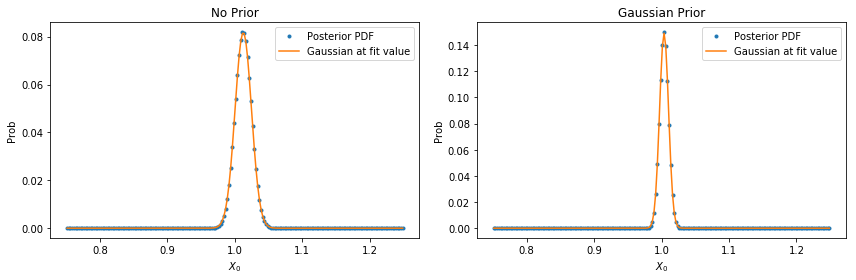

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x_prob,xcenter = get_posterior(x_fit_arr,chisq_arr,num_sm)
plt.plot(xcenter,x_prob,'.',label='Posterior PDF')
plt.plot(xcenter,Gauss_prob(xcenter,x_mean,x_std)/np.sum(Gauss_prob(xcenter,x_mean,x_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$X_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
x_prob,xcenter = get_posterior_prior(x_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,num_sm)
plt.plot(xcenter,x_prob,'.',label='Posterior PDF')
plt.plot(xcenter,Gauss_prob(xcenter,x_mean_p,x_std_p)/np.sum(Gauss_prob(xcenter,x_mean_p,x_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$X_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

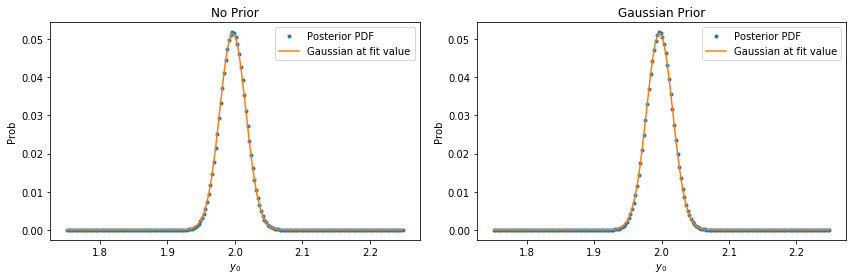

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
y_prob,ycenter = get_posterior(y_fit_arr,chisq_arr,num_sm)
plt.plot(ycenter,y_prob,'.',label='Posterior PDF')
plt.plot(ycenter,Gauss_prob(ycenter,y_mean,y_std)/np.sum(Gauss_prob(ycenter,y_mean,y_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$y_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
y_prob,ycenter = get_posterior_prior(y_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,num_sm)
plt.plot(ycenter,y_prob,'.',label='Posterior PDF')
plt.plot(ycenter,Gauss_prob(ycenter,y_mean_p,y_std_p)/np.sum(Gauss_prob(ycenter,y_mean_p,y_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$y_0$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

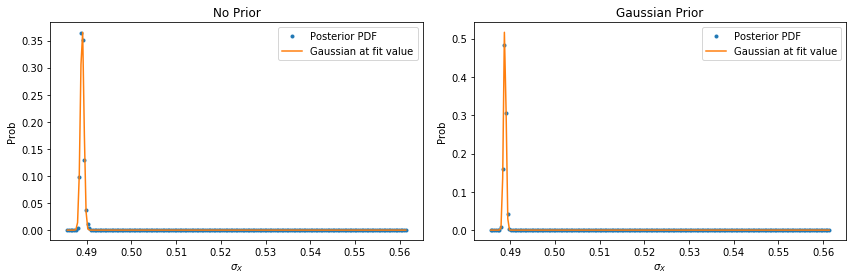

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
xsig_prob,xsigcenter = get_posterior(xsig_fit_arr,chisq_arr,num_sm)
plt.plot(xsigcenter,xsig_prob,'.',label='Posterior PDF')
plt.plot(xsigcenter,Gauss_prob(xsigcenter,xsig_mean,xsig_std)/np.sum(Gauss_prob(xsigcenter,xsig_mean,xsig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
xsig_prob,xsigcenter = get_posterior_prior(xsig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,num_sm)
plt.plot(xsigcenter,xsig_prob,'.',label='Posterior PDF')
plt.plot(xsigcenter,Gauss_prob(xsigcenter,xsig_mean_p,xsig_std_p)/np.sum(Gauss_prob(xsigcenter,xsig_mean_p,xsig_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_X$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

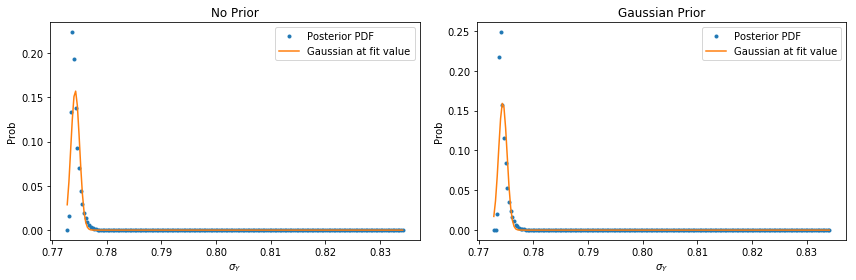

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ysig_prob,ysigcenter = get_posterior(ysig_fit_arr,chisq_arr,num_sm)
plt.plot(ysigcenter,ysig_prob,'.',label='Posterior PDF')
plt.plot(ysigcenter,Gauss_prob(ysigcenter,ysig_mean,ysig_std)/np.sum(Gauss_prob(ysigcenter,ysig_mean,ysig_std))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_Y$")
plt.ylabel("Prob")
plt.legend()
plt.title("No Prior")
plt.subplot(1,2,2)
ysig_prob,ysigcenter = get_posterior_prior(ysig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,num_sm)
plt.plot(ysigcenter,ysig_prob,'.',label='Posterior PDF')
plt.plot(ysigcenter,Gauss_prob(ysigcenter,ysig_mean_p,ysig_std_p)/np.sum(Gauss_prob(ysigcenter,ysig_mean_p,ysig_std_p))
         ,label='Gaussian at fit value')
plt.xlabel(r"$\sigma_Y$")
plt.ylabel("Prob")
plt.legend()
plt.title("Gaussian Prior")
plt.tight_layout()

## Corner Plots

In [25]:
def posterior2vals(values,chisq,maxfreq=100):
    '''
    Converts an array of values and Chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2) #Likliehood given Chi Squared statistic
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)

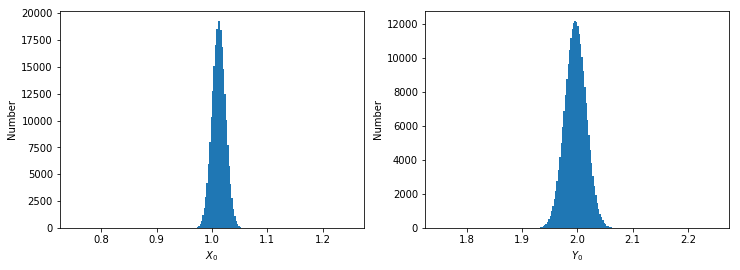

In [26]:
sample = 1000
x_trials = posterior2vals(x_fit_arr,chisq_arr,sample)
y_trials = posterior2vals(y_fit_arr,chisq_arr,sample)
xsig_trials = posterior2vals(xsig_fit_arr,chisq_arr,sample)
ysig_trials = posterior2vals(ysig_fit_arr,chisq_arr,sample)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x_trials,num_sm,range=(np.min(x_sm),np.max(x_sm)))
plt.xlabel(r"$X_0$")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(y_trials,num_sm,range=(np.min(y_sm),np.max(y_sm)))
plt.xlabel(r"$Y_0$")
plt.ylabel("Number")
plt.show()

In [27]:
data_comb = np.vstack([x_trials,y_trials,xsig_trials,ysig_trials])
data_comb = data_comb.T
print(data_comb.shape)

(234973, 4)


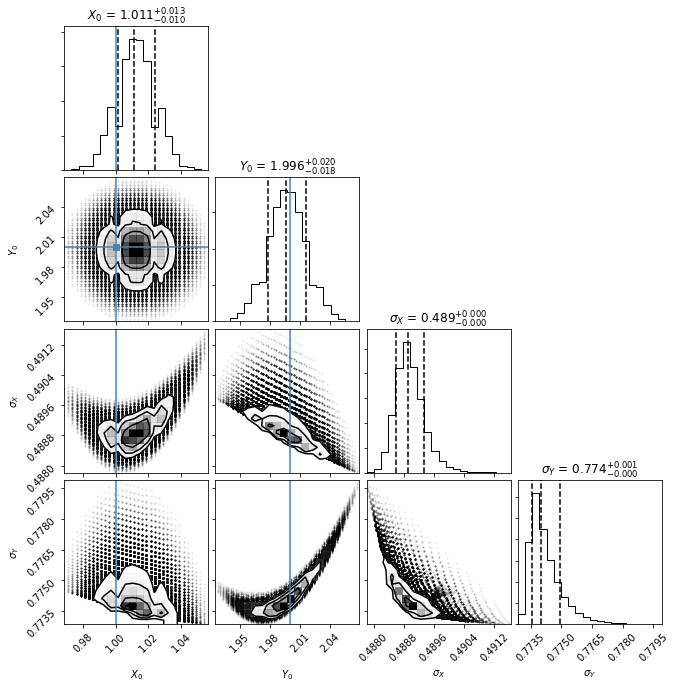

In [28]:
corner.corner(data_comb,labels=[r"$X_0$", r"$Y_0$", r"$\sigma_{X}$", r"$\sigma_Y$"],
                       quantiles=[0.16, 0.5, 0.84],truths=[1.0,2.0,0.5,0.75],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()

## Corner Plots (now with Priors)

In [29]:
def posterior2vals_prior(values,chisq,prior_val,prior_mean,prior_std,maxfreq=100):
    '''
    Converts an array of values and chi-squared into a 1-d array length num with each value appearing at
    the rate given by the probability.
    
    Arguments:
        values: The data values of interest
        chisq: The chi-squared of each data value
        prior_val: The values array for the X_i to be used for the Gaussian prior
        prior_mean: The Gaussian Prior on the mean (X_0)
        prior_std: The Gaussian Prior Standard Deviation Sigma_X.
        maxfreq: The number of times the most probable set of values appears (Default 100).
    Returns:
        A numpy array of values appearing at a frequency equal to thir probability.
    '''
    lh_prob = np.exp(-chisq/2)*np.exp(-0.5*((prior_val-prior_mean)**2
                                        )/prior_std**2) #Likliehood and Gaussian Prior
    norm = np.sum(lh_prob)
    lh_prob = lh_prob/norm
   
    max_prob = np.max(lh_prob)
    
    factor = maxfreq/max_prob
    new_prob = lh_prob*factor
    
    new_values = list()
    for i in range(len(new_prob)):
        number = np.floor(new_prob[i])
        if number > 0:
            new_values.extend(np.repeat(values[i],number))
    new_values_arr = np.array(new_values)
    return(new_values_arr)

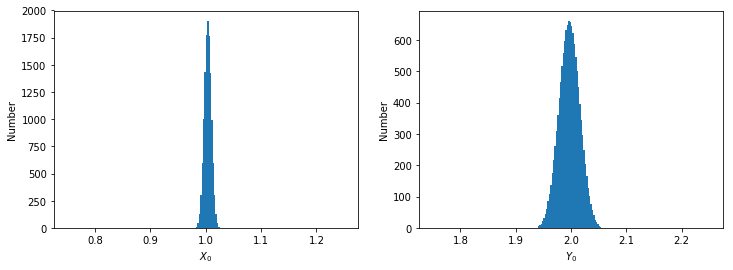

In [30]:
x_trials_p = posterior2vals_prior(x_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,100)
y_trials_p = posterior2vals_prior(y_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,100)
xsig_trials_p = posterior2vals_prior(xsig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,100)
ysig_trials_p = posterior2vals_prior(ysig_fit_arr,chisq_arr,x_fit_arr,prior_mean,prior_std,100)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(x_trials_p,num_sm,range=(np.min(x_sm),np.max(x_sm)))
plt.xlabel(r"$X_0$")
plt.ylabel("Number")
plt.subplot(1,2,2)
plt.hist(y_trials_p,num_sm,range=(np.min(y_sm),np.max(y_sm)))
plt.xlabel(r"$Y_0$")
plt.ylabel("Number")
plt.show()

In [31]:
data_comb_p = np.vstack([x_trials_p,y_trials_p,xsig_trials_p,ysig_trials_p])
data_comb_p = data_comb_p.T
print(data_comb_p.shape)

(12480, 4)


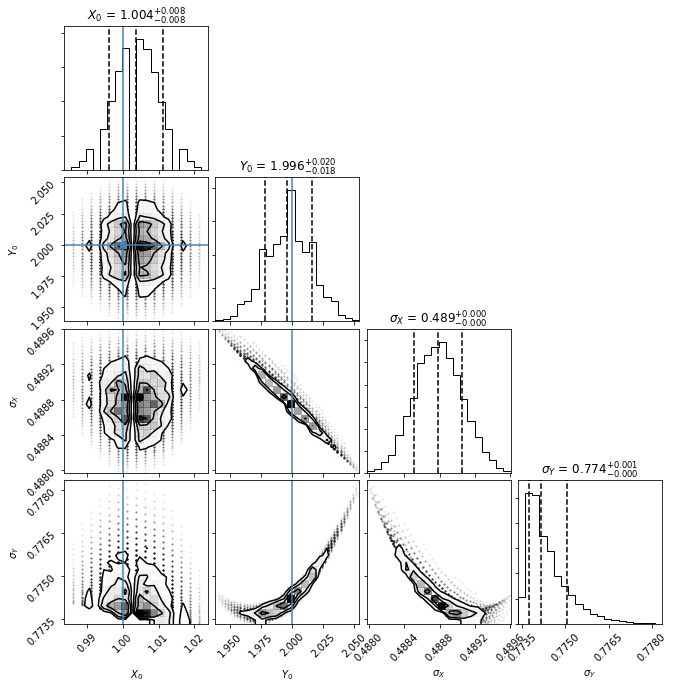

In [32]:
corner.corner(data_comb_p,labels=[r"$X_0$", r"$Y_0$", r"$\sigma_{X}$", r"$\sigma_Y$"],
                       quantiles=[0.16, 0.5, 0.84],truths=[1.0,2.0,0.5,0.75],
                       show_titles=True, title_fmt="0.3f",title_kwargs={"fontsize": 12})
plt.show()